Student: Tarasov Oleksandr

StudentID: 2786693

# Exercise: Attention and Transformer

In the last lecture you learned about the attention mechanism and the transformer architecture. Just like the RNNs we covered in last week's exercise these were first introduced in the context on Natural language processing in order to better process sequences of data. The transformer architecture has since become the state-of-the-art in many NLP tasks, and has been adapted to many other domains as well. Recently large generative models based on the transformer architecture have been developed and achieved state-of-the-art results in many domains. Probably the most well known example is OpenAI's ChatGPT.
Sure, we will not be able to construct something quite as large as ChatGPT in this exercise, but we will construct a small transformer model that can generate text. Just like last week, we will train this model on a dataset of Shakespeare's writing, and see how well it can learn to generate text in the style of Shakespeare. For simplicity, we will once again use a character-level model, where the model will predict the next character in a sequence of characters. This also means we will not deal with byte-pair endocing or any other kind of sophisticated tokenization. Also, since not all of you may have access to a GPU, we'll train this model on the CPU. This means that we'll have to use a smaller model and train for fewer iterations. Unfortunately, this also means we cannot take advantage of the transformer's massive advantage of parallelization, but we'll still be able to see how the transformer's self-attention mechanism works.

To start things of, we'll import our dependencies and load the dataset. This week, we'll use a bit more than just numpy.

In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
from dataclasses import dataclass
from torch.nn import functional as F
import os
import requests
import time

In [2]:
input_file_path = os.path.join(os.path.abspath(''), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("Unique characters:", ''.join(chars))
print(f"Vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) } # string to integer
itos = { i:ch for i,ch in enumerate(chars) } # integer to string
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
# create the train and validation splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

length of dataset in characters: 4,573,338
Unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz
Vocab size: 67
train has 4,116,004 tokens
val has 457,334 tokens


## The building blocks of the transformer

Like most neural network architectures, the transformer is composed of a number of layers. In a typical divide-and-conquer approach, we can break down the transformer into smaller, a bit simpler components, each of which can be implemented separately. To get you started, templates for the Layer normalization and the fully connected layer/MLP with GELU activation function are provided below.

In [3]:
# Today we'll focus on the transformer's self attention mechanism, so some parts of the architecture will provided.
# Here are the compelte modules for the Layer normalization and the fully connected layer/MLP with GELU activation function.
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.o_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.o_proj(x)
        x = self.dropout(x)
        return x

## Attention, please!

You will need to implement the self-attention mechanism yourself. To be more precise, this will be causal self-attention. To help you out, let's have another look at the transformer architecture:
![image.png]( 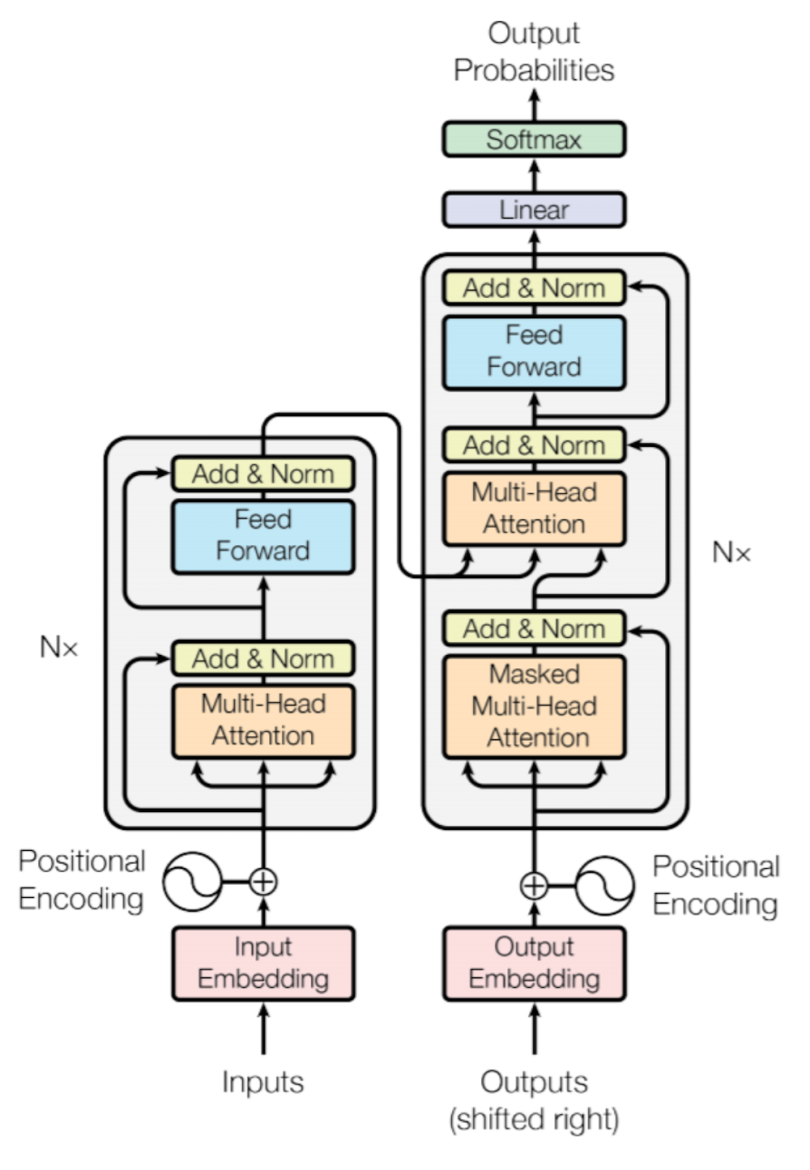)

As was covered in the lecture, the GPT architecture only uses the decoder portion of the original transformer. This means our model requires a special verion of the attention mechanims, called causal self-attention, or masked self-attention. Unlike the attention mechanism in the decoder, this means that the attention mechanism in the GPT model only allows each token to attend to the tokens that came before it in the sequence. This is done by masking out the attention to all tokens that come after the token in question. To better understand this concept consider the picture below. As stated, we mask the attention weighs. In the ilmentation this is done by setting the corresponding entries in the attention amtrix to -inf, once we have calculated the attention weights for all combinations, but before we apply the softmax function. Also, since we are not using an encoder in this setup, we do not need to include the encoder-decoder attention mechanism. Our Transformer block only consists of the masked multi-head se-fattention mechanism and the position-wise feedforward networks, as well as the residual connections and the normalisation in each layer.

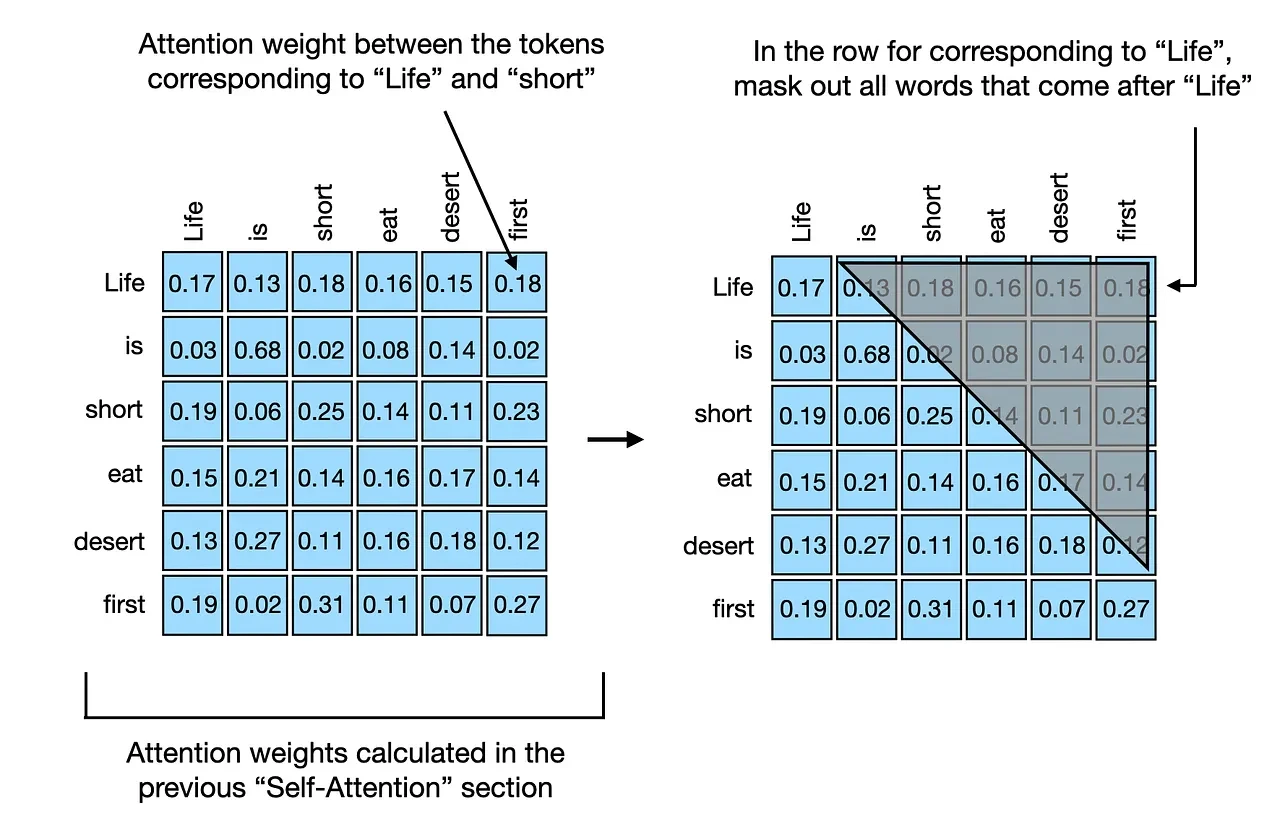

To help you with implementing the attention mechanism here is a figure from the famous blog post [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) (also consider having a look at [The Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)). While the information from the lecture slides should  be enough to implement this, these articles can really help with getting a more in-depth understanding of the transformer.

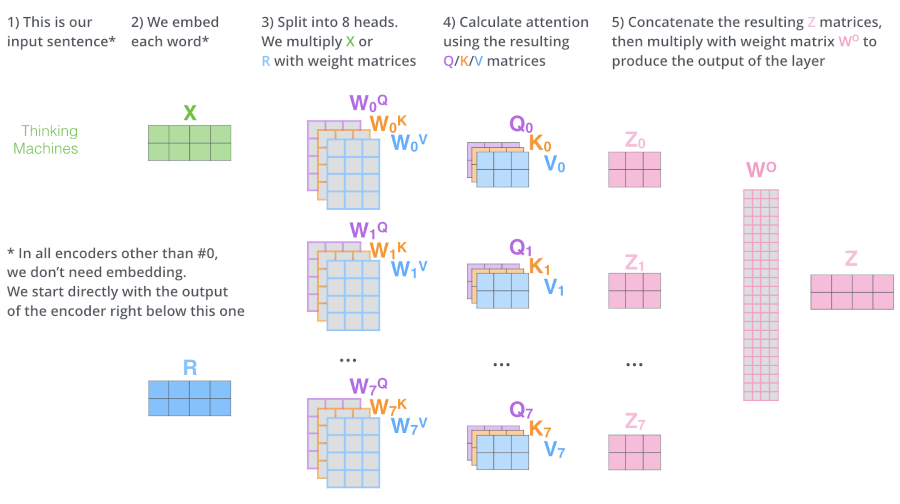


In [4]:
#THIS were you need to implement the attention mechanism yourself
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.Q = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.K = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.V = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # output projection
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd


    def forward(self, x):
        B, T, D = x.size()

        Q = self.Q(x)
        K = self.K(x)
        V = self.V(x)

        Q = Q.view(B, T, self.n_head, D // self.n_head).transpose(1, 2)
        K = K.view(B, T, self.n_head, D // self.n_head).transpose(1, 2)
        V = V.view(B, T, self.n_head, D // self.n_head).transpose(1, 2)

        attn_scores = Q @ K.transpose(-2, -1) / math.sqrt(D // self.n_head)

        mask = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T)
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        y = attn_weights @ V 

        # Reassemble the output
        y = y.transpose(1, 2).contiguous().view(B, T, D)  # (B, T, D)

        # Output projection
        y = self.o_proj(y)
        y = self.dropout(y)

    # Thanks to auto-grad, we do not need to worry about the backward pass of the attention mechanism. Wven if we
    # were toi do it manually, while it might get confusing when writing the acutal implementation, at its core it is
    # just a backpropagation through softmax and matrix multiplication operations.
        return y

# Now let's construct the transformer blocks, since we can construct our model by simply stacking
# these blocks on top of each other. The transformer block consists of a layer normalizations,
# self-attention and a fully connected layer with GELU activation function.
# We have all these parts implemented, so this is a simple task of putting them together.
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [5]:
# Using these blocks, we can now construct the full GPT model. The code will be given for you, but you should
# still try to understand how the model is constructed.

#dataclass for our model parameters with default values
@dataclass
class GPTConfig: # TODO: put correct defaults here for our case
    block_size: int = 64
    vocab_size: int = None
    n_layer: int = 6
    n_head: int = 4
    n_embd: int = 128
    dropout: float = 0.0
    bias: bool = True

# The GPT model is a simple stack of the transformer blocks, with an embedding layer and a final linear layer
# to map the output to a vocabulary distribution.
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        #These are the layers in our model:
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # token embeddings
            wpe = nn.Embedding(config.block_size, config.n_embd), # positional embeddings, unlike in the transformer covered in the lecture GPT learns them
            drop = nn.Dropout(config.dropout), # dropout layer
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # the actual transformer layers, we implemented them above. Stack 'em up!
            ln_f = LayerNorm(config.n_embd, bias=config.bias), #
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # we tie the weights of the language modelling head to the input embeddings

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('o_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size() # the sequences so far, batch x length
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t), non-encoded positional indices

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def configure_optimizers(self, weight_decay, learning_rate, betas, device):
        # start with all the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        extra_args = dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)

        return optimizer

    @torch.no_grad() # tell torch to not track the gradients, saves memory and computation since we are just generating  outputs, not training
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [6]:
#We need some more paramters to train the model
training_config = {
    "batch_size" : 12,
    "max_iters" : 2000,
    "learning_rate" : 1e-3, # quite high for a transformer, but we can afford that with smaller models
    "decay_lr" : True, # whether to decay the learning rate
    "warmup_iters" : 100, # not super necessary potentially
    "lr_decay_iters" : 2000, # make equal to max_iters usually
    "min_lr" : 1e-4, # learning_rate / 10 usually
    "betas" : (0.9, 0.99),
    "weight_decay" : 0.1,
    "eval_interval" : 250, # keep frequent because we'll overfit quickly on such a small example
    "eval_iters" : 20,
    "log_interval" : 50, # don't print too too often
    "grad_clip" : 1.0, # clip gradients at this value, or disable if == 0.0
    "output_interval": 100 # how often to output a sample of the model's output
}

# There are certain hyperparameters that we need to define for the model. I'll provide the default values for the
# Shakespeare model, but you can change these values if you want to examine their impact.
model_config = {
    "block_size" : 128, # spatial extent of the model for its context, i.e. size of the sequences we are training on
    "n_layer" : 6, # number of layers
    "n_head" :  4, # number of attention heads
    "n_embd" :  256, # embedding dimension in the model
    "dropout" : 0.0, # dropout probability
    "bias" : False, # True: bias in Linears and LayerNorms, like GPT-2. False: a bit faster, and potentially better
    "vocab_size" : vocab_size # Size of the vocabulary, this may depend on the dataset you are using
}

#make one config object that we can pass around
config = {**model_config, **training_config}
print(config)

{'block_size': 128, 'n_layer': 6, 'n_head': 4, 'n_embd': 256, 'dropout': 0.0, 'bias': False, 'vocab_size': 67, 'batch_size': 12, 'max_iters': 2000, 'learning_rate': 0.001, 'decay_lr': True, 'warmup_iters': 100, 'lr_decay_iters': 2000, 'min_lr': 0.0001, 'betas': (0.9, 0.99), 'weight_decay': 0.1, 'eval_interval': 250, 'eval_iters': 20, 'log_interval': 50, 'grad_clip': 1.0, 'output_interval': 100}


In [7]:
tokens_per_iter = config["batch_size"] * config["block_size"]
print(f"tokens per iteration will be: {tokens_per_iter:,}")
torch.manual_seed(42) # we set a seed for reproducibility of our results
device = 'cuda'  #For accessibility, we'll only use the cpu for this example
ptdtype = torch.float16

def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = train_ids
    else:
        data = val_ids
    ix = torch.randint(len(data) - config["block_size"], (config["batch_size"],))
    #x = torch.stack([torch.from_numpy((data[i:i+config["block_size"]]).astype(np.int64)) for i in ix])
    x = torch.stack([torch.from_numpy(np.array(data[i:i+config["block_size"]])) for i in ix])
    y = torch.stack([torch.from_numpy(np.array(data[i+1:i+1+config["block_size"]]).astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(config["eval_iters"])
        for k in range(config["eval_iters"]):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

@torch.no_grad()
def printSampleOutput():
    model.eval()
    # randomly chose a token to start generating our output
    tokens = [np.random.choice(vocab_size)]
    x = (torch.tensor(tokens, dtype=torch.long, device=device)[None, ...])
    y = model.generate(x, 50, temperature=0.8, top_k=5)
    print(f"+++ Generated output: +++\n{decode(y[0].tolist())}\n+++++++++++++++++++++++++")
    model.train()

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < config["warmup_iters"]:
        return config["learning_rate"] * it / config["warmup_iters"]
    # 2) if it > lr_decay_iters, return min learning rate
    if it > config["lr_decay_iters"]:
        return config["min_lr"]
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - config["warmup_iters"]) / (config["lr_decay_iters"] - config["warmup_iters"])
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return config["min_lr"] + coeff * (config["learning_rate"] - config["min_lr"])

model_args = dict(n_layer=config["n_layer"], n_head=config["n_head"], n_embd=config["n_embd"], block_size=config["block_size"],
                  bias=config["bias"], vocab_size=vocab_size, dropout=config["dropout"])
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)
scaler = torch.cuda.amp.GradScaler(enabled=(ptdtype == torch.float16))
optimizer = model.configure_optimizers(config["weight_decay"], config["learning_rate"], config["betas"], device)
iter_num = 0
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if config["decay_lr"] else config["learning_rate"]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if iter_num % config["output_interval"] == 0:
        printSampleOutput()
    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % config["eval_interval"] == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # forward backward update
    logits, loss = model(X, Y)
    # immediately async prefetch next batch while model is doing the forward pass on the GPU
    X, Y = get_batch('train')
    # backward pass, with gradient scaling if training in fp16
    scaler.scale(loss).backward()
    # clip the gradient
    if config["grad_clip"] != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % config["log_interval"] == 0:
        # get loss as float. note: this is a CPU-GPU sync point
        lossf = loss.item()
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1

    # termination conditions
    if iter_num > config["max_iters"]:
        break

tokens per iteration will be: 1,536
number of parameters: 4.74M
num decayed parameter tensors: 38, with 4,768,512 parameters
num non-decayed parameter tensors: 13, with 3,328 parameters
+++ Generated output: +++
X,,,,,iFaaU::[[V'WFpp:[['LTiyW:::[[UZZciiFFp Lq---!
+++++++++++++++++++++++++
step 0: train loss 4.2148, val loss 4.2164
iter 0: loss 4.2117, time 643.73ms
iter 50: loss 2.6143, time 13.75ms
+++ Generated output: +++
DONINIO:
I athinon at thind walono tere thindounoro
+++++++++++++++++++++++++
iter 100: loss 2.5593, time 172.43ms
iter 150: loss 2.5348, time 13.78ms
+++ Generated output: +++
ZIUS:
Ang tithe arane mere mute wit meand henghe te
+++++++++++++++++++++++++
iter 200: loss 2.4646, time 166.79ms
step 250: train loss 2.4116, val loss 2.4208
iter 250: loss 2.3756, time 218.01ms
+++ Generated output: +++
[
An handene sit han thin trow thin to th hing he h
+++++++++++++++++++++++++
iter 300: loss 2.4206, time 165.88ms
iter 350: loss 2.1703, time 13.72ms
+++ Generated output

## Something to think about...

Is you model running? Does the output at end up looking somewhat like English after a few minutes? If so, congratulations! You have successfully implemented the attention mechanism of the transformer. You may want to play around with the parameters a little bit: How does changing the block size affect the training and the results. What about the embedding dimensions? Maybe try training a bigger model with alternative or additional texts! Scaling up the model will quickly cause the training to take quite a bit longer. Which in turn will give you the time to consider some questions ;P

1. We just finished building a neural network that is able to generate text.
Suppose we do not want to use a list of example texts and the cross-entropy loss to train our model and are looking for an alternative.
someone suggests the following:
``From the lecture, we know that a loss function must give a number that indicates how bad the model is, such that we can minimize this during gradient descent.
Why don't we ask people to rate the quality of generated texts and use them as the loss function?''
Assuming we want to optimize our model via backpropagation based on this feedback, what are potential challenges with this approach that we would need to overcome?

2. A convolution transforms the input by weighting the input values with a learned filter.
A self-attention layer also combines the values that are computed from the input using weights.
What are the differences between the two?



1. Challenges for human accession:
- people can be biased
- the process will be too slow
- it would be hard to estimate the discrete value

2. We will compare it by multiple points:
- Receptive field
CNNs consider features in a predefined window only. It helps to find local features. Attention layers use weighted combination of all of the input sequence and consider global relationships.
- weights sharing
CNNs use predefined kernels which are just tuned during by training. Attention layers use weights calculated dynamically from the input itself.